In [2]:
import math
import os
os.sys.path.append("../")
import re
from typing import Union

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import spatial, stats
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN

from tqdm import tqdm 
from scipy.io import mmread
import scanpy as sc

#import MSDiversity as msd
import graph
import utils

In [4]:
import scanpy as sc

In [5]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

In [6]:
data_dir = '../../../../../tonsil/'

# Load data
# combine data os path
protein = pd.read_csv(os.path.join(data_dir, 'tonsil_codex.csv')) # ~178,000 codex cells

In [7]:
# protein expression in protein
protein_features = ['CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8',
       'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'cytokeratin', 'CD2',
       'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IGM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha', 'Ecadherin']
protein_exp = protein[protein_features]

# Cell-type Composition Vector

In [ ]:
# Get neighborhood composition
ks = 20
locations = protein[['centroid_x', 'centroid_y']].values
feature_labels = protein['cluster.term'].values
spatial_knn_indices = graph.get_spatial_knn_indices(locations=locations, n_neighbors=ks, method='kd_tree') 
cell_nbhd = utils.get_neighborhood_composition(knn_indices=spatial_knn_indices, labels=feature_labels)
#print(cell_nbhd)
#print(cell_nbhd.shape) # ~178,000 neighbors x 6 cell typs percentage

In [ ]:
cell_nbhd.shape

(178919, 6)

# Protein Vector

In [ ]:
avg_exp = utils.get_avg_expression_neighbors(protein_exp, spatial_knn_indices)
avg_exp_df = np.stack(avg_exp)

Computing avg expression: 100%|███████| 178919/178919 [00:39<00:00, 4578.05it/s]


# RNA Vector

In [ ]:
df_rna_match = pd.read_csv('../../../../../tonsil/tonsil_codex_rna.csv')
df_rna_match.columns = ['rna', 'protein', 'score']

In [ ]:
rna = mmread("../../../../../tonsil/tonsil_rna_counts.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('../../../../../tonsil/tonsil_rna_names.csv')['names'].to_numpy()

In [ ]:
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32)
rna_adata.var_names = rna_names

In [ ]:
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=2000)
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
rna_exp = rna_adata.X.toarray()

In [ ]:
rna_matched = []
for i in tqdm(range(protein.shape[0]), total=protein.shape[0], desc='Assigning rna expression'):
    if i in df_rna_match['protein'].values:
        rna_idx = df_rna_match[df_rna_match['protein'] == i]['rna']
        rna_exp_each = rna_exp[rna_idx][0]
        rna_matched.append(rna_exp_each)
    else:
        rna_matched.append(np.array([0]*rna_exp.shape[1]))

Assigning rna expression: 100%|███████| 178919/178919 [00:42<00:00, 4238.42it/s]


In [ ]:
rna_matched_protein_order = np.stack(rna_matched)

In [ ]:
rna_matched_df = pd.DataFrame(rna_matched_protein_order)

# calculate the average rna expression based on rna_matched_protein_order for each cluster
avg_exp_rna = utils.get_avg_expression_neighbors(rna_matched_df, spatial_knn_indices)
avg_exp_rna_df = np.stack(avg_exp_rna)

Computing avg expression: 100%|███████| 178919/178919 [01:03<00:00, 2814.70it/s]


In [ ]:
# save vectors
np.save('cell_nbhd.npy', cell_nbhd)
np.save('avg_exp_df.npy', avg_exp_df)
np.save('avg_exp_rna_df.npy', avg_exp_rna_df)

In [15]:
cell_nbhd = np.load('cell_nbhd.npy')
avg_exp_df = np.load('avg_exp_df.npy')
avg_exp_rna_df = np.load('avg_exp_rna_df.npy')

In [16]:
# save to csv for R to use
np.savetxt('cell_nbhd.csv', cell_nbhd, delimiter=',')
np.savetxt('avg_exp_df.csv', avg_exp_df, delimiter=',')
np.savetxt('avg_exp_rna_df.csv', avg_exp_rna_df, delimiter=',')

# Clustering Algorithms
- K-means: fast and effective
- Hierarchical clustering
- Birch
- Clustering methods known to not scale up
    - Gaussian mixtures
    - Mean-shift


## Subsample

In [8]:
# Subsample for now
indices_subsample = np.random.choice(cell_nbhd.shape[0], 30000, replace=False)
cell_nbhd_sample = cell_nbhd[indices_subsample]
protein_sample = avg_exp_df[indices_subsample]
rna_sample = avg_exp_rna_df[indices_subsample]
#comb_sample = avg_exp_comb_df[indices_subsample]

In [11]:
protein_subsample = protein.iloc[indices_subsample]

# BIRCH Clustering

### Cellular composition

In [10]:
n_cluster = 10
birch = Birch(n_clusters=n_cluster, threshold=0.1).fit(cell_nbhd)

In [12]:
protein['cluster_composition_birch'] = birch.labels_.astype(str)

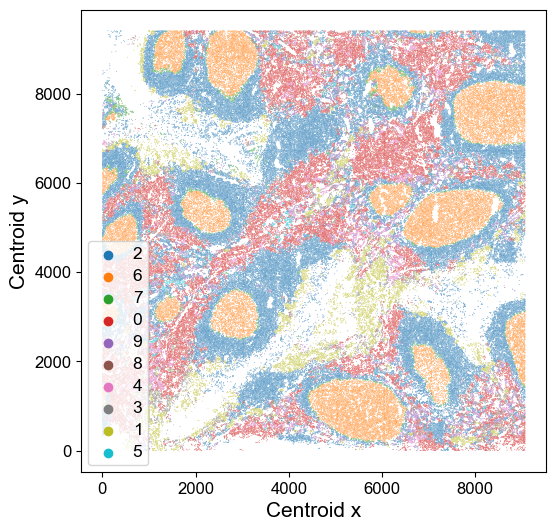

In [13]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", 
                hue="cluster_composition_birch", s = 0.3, rasterized=True)
               #hue_order = cell_type_order)#,
               #palette="muted")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)
plt.show()

### Average protein expression

In [17]:
n_cluster = 10
birch_protein = Birch(n_clusters=n_cluster, threshold=0.1).fit(protein_sample)

/var/folders/p9/l9_cp9p96kg_0zk6v9v47ly00000gn/T/ipykernel_74957/3190076912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_subsample['cluster_protein_birch'] = birch_protein.labels_.astype(str)


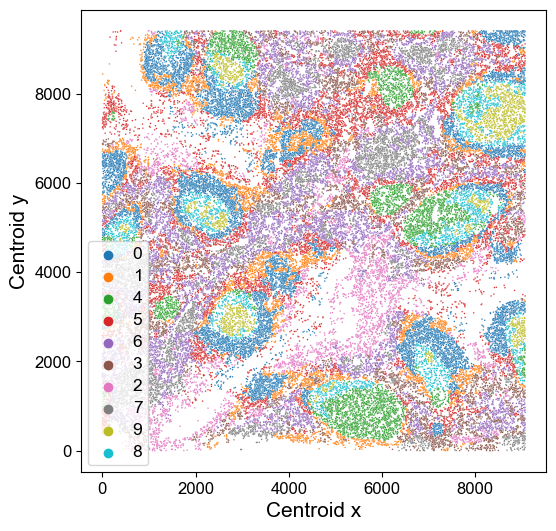

In [20]:
protein_subsample['cluster_protein_birch'] = birch_protein.labels_.astype(str)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_subsample, x="centroid_x", y="centroid_y", 
                hue="cluster_protein_birch", s = 1.8, rasterized=True)
               #hue_order = cell_type_order)#,
               #palette="muted")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)
plt.show()

### Average RNA expression

In [9]:
n_cluster = 10
birch_rna = Birch(n_clusters=n_cluster, threshold=0.1).fit(rna_sample)

/var/folders/p9/l9_cp9p96kg_0zk6v9v47ly00000gn/T/ipykernel_76755/1267743438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_subsample['cluster_rna_birch'] = birch_rna.labels_.astype(str)


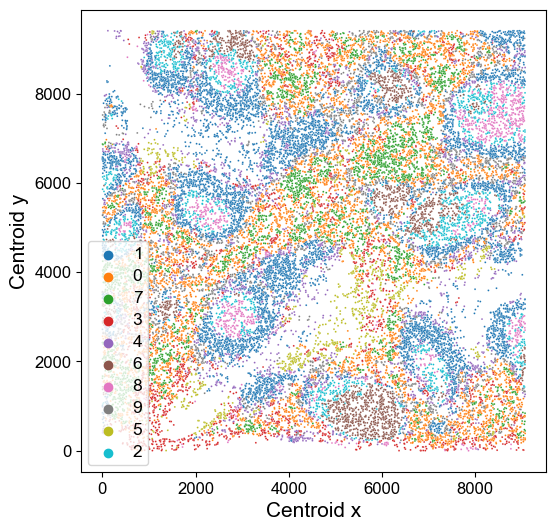

In [13]:
protein_subsample['cluster_rna_birch'] = birch_rna.labels_.astype(str)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_subsample, x="centroid_x", y="centroid_y", 
                hue="cluster_rna_birch", s = 1.8, rasterized=True)
               #hue_order = cell_type_order)#,
               #palette="muted")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)
plt.show()

# K-means Clustering

### Cellular composition

In [ ]:
# k-means clustering on cell_nbhd
n_cluster = 10
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(cell_nbhd)
#print(kmeans.labels_)
protein['cluster_composition'] = kmeans.labels_.astype(str)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cell_type_order = sorted(protein['cluster.term'].unique())

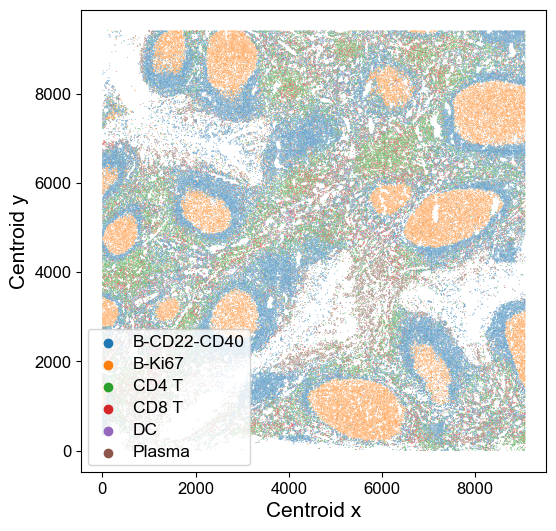

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", 
                hue="cluster.term", s = 0.3, rasterized=True,
               hue_order = cell_type_order)#,
               #palette="muted")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)
plt.show()

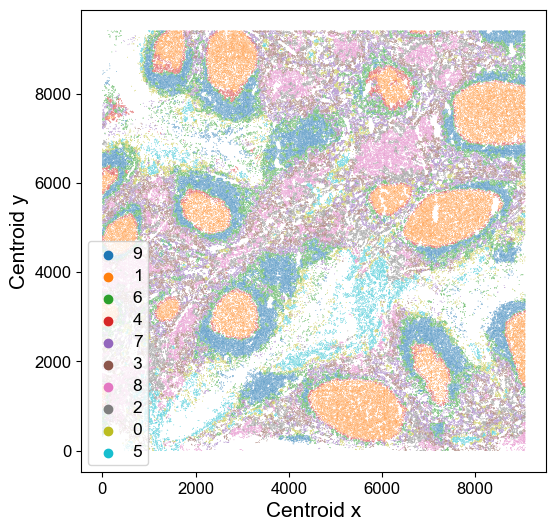

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", 
                hue="cluster_composition", s = 0.3, rasterized=True)
               #hue_order = cell_type_order)#,
               #palette="muted")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)
plt.show()

### Average protein expression

In [ ]:
# k-means clustering on avg_exp_df
n_cluster = 10
kmeans_protein = KMeans(n_clusters=n_cluster, random_state=0).fit(avg_exp_df)
protein['cluster_protein'] = kmeans_protein.labels_.astype(str)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
order_clusters_protein = sorted(protein['cluster_protein'].unique())

In [ ]:
protein['cluster_protein_order'] = protein['cluster_protein']
index1 = protein[protein['cluster_protein_order'] == '1'].index
index2 = protein[protein['cluster_protein_order'] == '9'].index
protein.loc[index1, 'cluster_protein_order'] = '9'
protein.loc[index2, 'cluster_protein_order'] = '1'

index3 = protein[protein['cluster_protein_order'] == '7'].index
index4 = protein[protein['cluster_protein_order'] == '2'].index
protein.loc[index3, 'cluster_protein_order'] = '2'
protein.loc[index4, 'cluster_protein_order'] = '7'

index5 = protein[protein['cluster_protein_order'] == '0'].index
index6 = protein[protein['cluster_protein_order'] == '5'].index
protein.loc[index5, 'cluster_protein_order'] = '5'
protein.loc[index6, 'cluster_protein_order'] = '0'

index7 = protein[protein['cluster_protein_order'] == '2'].index
index8 = protein[protein['cluster_protein_order'] == '9'].index
protein.loc[index7, 'cluster_protein_order'] = '9'
protein.loc[index8, 'cluster_protein_order'] = '2'

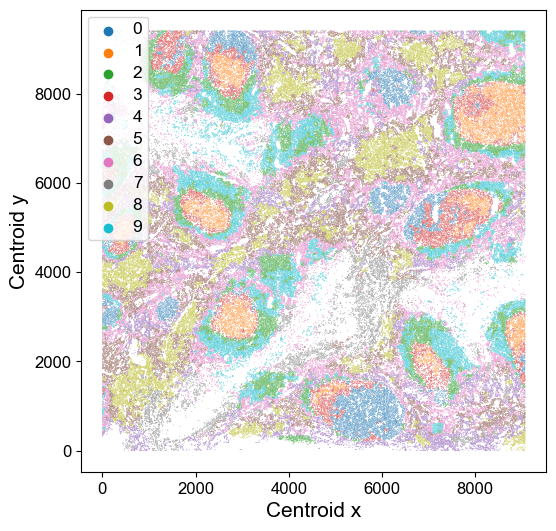

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_protein_order", 
                hue_order=order_clusters_protein, s=0.3, rasterized=True)#,
                #palette="bright")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)
plt.show()

### Average RNA expression

In [ ]:
n_cluster = 10
kmeans_rna = KMeans(n_clusters=n_cluster, random_state=0).fit(avg_exp_rna_df)
protein['cluster_rna'] = kmeans_rna.labels_.astype(str)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
order_clusters_rna = sorted(protein['cluster_rna'].unique())
protein['cluster_rna_order'] = protein['cluster_rna']

index1 = protein[protein['cluster_rna_order'] == '1'].index
index2 = protein[protein['cluster_rna_order'] == '8'].index

protein.loc[index1, 'cluster_rna_order'] = '8' 
protein.loc[index2, 'cluster_rna_order'] = '1' 

index3 = protein[protein['cluster_rna_order'] == '2'].index
index4 = protein[protein['cluster_rna_order'] == '3'].index

protein.loc[index3, 'cluster_rna_order'] = '3' 
protein.loc[index4, 'cluster_rna_order'] = '2'

index5 = protein[protein['cluster_rna_order'] == '2'].index
index6 = protein[protein['cluster_rna_order'] == '4'].index

protein.loc[index5, 'cluster_rna_order'] = '4' 
protein.loc[index6, 'cluster_rna_order'] = '2' 

index7 = protein[protein['cluster_rna_order'] == '5'].index
index8 = protein[protein['cluster_rna_order'] == '0'].index

protein.loc[index7, 'cluster_rna_order'] = '0' 
protein.loc[index8, 'cluster_rna_order'] = '5' 

index9 = protein[protein['cluster_rna_order'] == '4'].index
index10 = protein[protein['cluster_rna_order'] == '8'].index

protein.loc[index9, 'cluster_rna_order'] = '8' 
protein.loc[index10, 'cluster_rna_order'] = '4' 

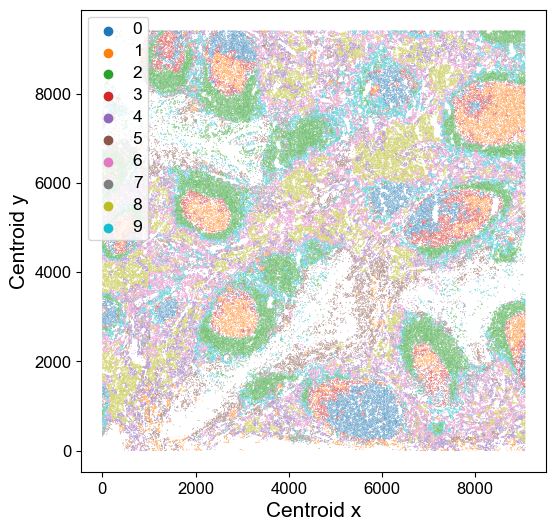

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_rna_order", 
                hue_order=order_clusters_protein, s=0.3, rasterized=True)#,
                #palette="bright")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

#plt.savefig('../figures/tonsil/tonsil_avgrna_order.png')
#plt.savefig('../figures/tonsil/tonsil_avgrna_order.svg', dpi=300)
plt.show()

# Hierarchical Clustering 

In [ ]:
# Subsample for hierarchical clustering for now
indices_subsample = np.random.choice(cell_nbhd.shape[0], 30000, replace=False)
cell_nbhd_sample = cell_nbhd[indices_subsample]
protein_sample = avg_exp_df[indices_subsample]
rna_sample = avg_exp_rna_df[indices_subsample]
comb_sample = avg_exp_comb_df[indices_subsample]

In [ ]:
cell_hclust = cell_nbhd_sample
protein_hclust = protein_sample
rna_hclust = rna_sample
comb_hclust = comb_sample

### Cellular composition

In [ ]:
# hierarchical clustering on cell_nbhd
n_clusters = 10
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='complete')
hc.fit(cell_hclust)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=10)

/var/folders/p9/l9_cp9p96kg_0zk6v9v47ly00000gn/T/ipykernel_54682/1835075414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_subsample['cluster_composition_hc'] = hc.labels_.astype(str)


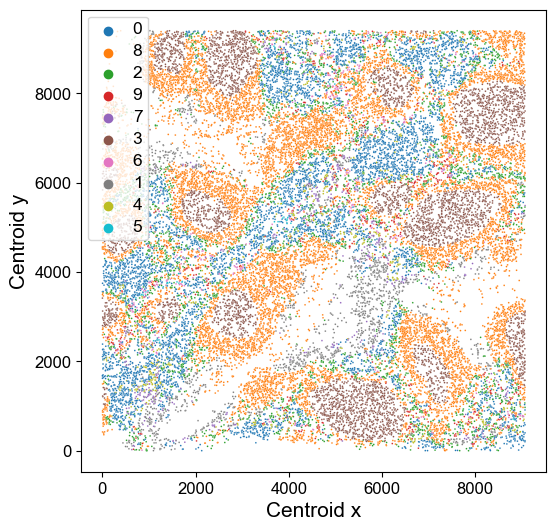

In [ ]:
protein_subsample = protein.iloc[indices_subsample]

# Assign cluster labels to the protein DataFrame
protein_subsample['cluster_composition_hc'] = hc.labels_.astype(str)

# Plot the clusters
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_subsample, x="centroid_x", y="centroid_y", 
                hue="cluster_composition_hc", 
                s=1.5, rasterized=True)  # , palette="bright"

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.show()

### Protein expression

In [ ]:
# hierarchical clustering on cell_nbhd
n_clusters = 10
hc_protein = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='complete')
hc_protein.fit(protein_hclust)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='cosine', linkage='complete', n_clusters=10)

/var/folders/p9/l9_cp9p96kg_0zk6v9v47ly00000gn/T/ipykernel_54682/3461174056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_subsample['cluster_protein_hc'] = hc_protein.labels_.astype(str)


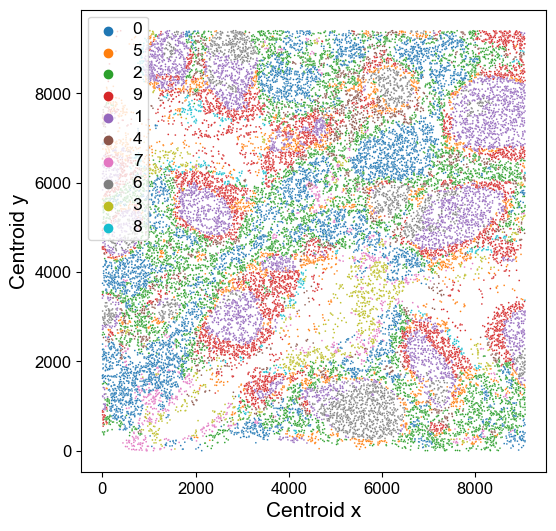

In [ ]:
# Assign cluster labels to the protein DataFrame
protein_subsample['cluster_protein_hc'] = hc_protein.labels_.astype(str)

# Plot the clusters
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_subsample, x="centroid_x", y="centroid_y", 
                hue="cluster_protein_hc", 
                s=1.5, rasterized=True)  # , palette="bright"

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.show()

### RNA expression

In [ ]:
# hierarchical clustering on cell_nbhd
n_clusters = 10
# NEED TO CHANGE COSINE TO EUCLIDEAN HERE FOR RNA
hc_rna = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')
hc_rna.fit(rna_hclust)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=10)

/var/folders/p9/l9_cp9p96kg_0zk6v9v47ly00000gn/T/ipykernel_54682/101110736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_subsample['cluster_rna_hc'] = hc_rna.labels_.astype(str)


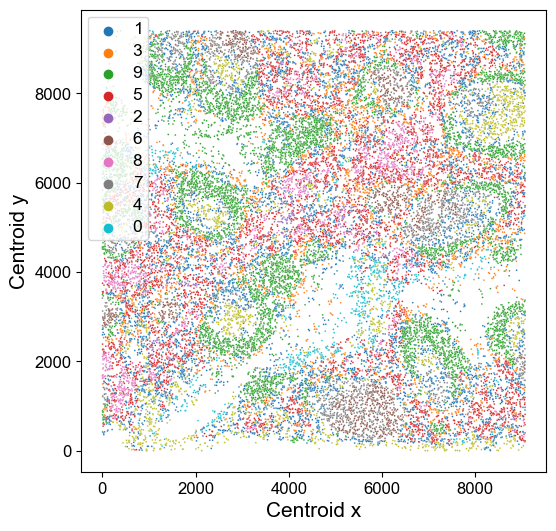

In [ ]:
# Assign cluster labels to the protein DataFrame
protein_subsample['cluster_rna_hc'] = hc_rna.labels_.astype(str)

# Plot the clusters
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_subsample, x="centroid_x", y="centroid_y", 
                hue="cluster_rna_hc", 
                s=1.5, rasterized=True)  # , palette="bright"

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.show()